# **Import necessary libraries**

In [277]:
import pandas as pd # to load dataset
import numpy as np # for mathematic equation
import matplotlib.pyplot as plt # to plot the graph
import seaborn as sns

from sklearn.model_selection import train_test_split # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences # to do padding or truncating
from tensorflow.keras.models import Sequential # the model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # save model
from tensorflow.keras.models import load_model   # load saved model
from sklearn.metrics import accuracy_score, confusion_matrix
import re

!pip install keras-tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters




# **Declaring the English stop words**

In [278]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Load and Preprocess data**

In [279]:
def load_dataset(data_path):
    df = pd.read_csv(data_path)
    x_data = df['tweet']
    y_data = df['label']

    #Preprocess Tweet
    x_data = x_data.str.lower()
    x_data

    return x_data, y_data


x_train, y_train = load_dataset('/content/sample_data/phm_train.csv')
x_test, y_test = load_dataset('/content/sample_data/phm_test.csv')

#Train to test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# **Encode Review**

In [280]:
#Tokenization
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(x_val)

max_length = int(np.ceil(np.mean([len(tweet) for tweet in x_train])))

#Padding
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')

total_words = len(tokenizer.word_index) + 1
print("Total Words: ",total_words)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)


Total Words:  11344
Encoded X Train
 [[    1    33    24 ...   355   168    18]
 [    3     2    50 ...   500    19  4728]
 [    3     2    20 ...     0     0     0]
 ...
 [   14    56   182 ...    35    30     0]
 [   27    34 11340 ...   968   210   110]
 [    1    20    11 ...     0     0     0]] 

Encoded X Test
 [[ 56  17 188 ...  74   6 377]
 [  1  25 634 ... 460   6  53]
 [  1 468   1 ...  15   8 572]
 ...
 [  3   2 225 ...   0   0   0]
 [  3   2  11 ...   0   0   0]
 [122  12  29 ...   0   0   0]] 

Maximum review length:  16


# **LSTM Model**

In [281]:
#Build the LSTM Model

#ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model_lstm = Sequential()
model_lstm.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model_lstm.add(LSTM(LSTM_OUT))
model_lstm.add(Dense(1, activation='sigmoid'))

#print(model_lstm.summary())



In [282]:
#Set Hyperparameters
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [283]:
#LSTM Model Training
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [284]:
#LSTM Model Fitting
LSTM_Hitory = model_lstm.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint, early_stop], validation_data=(x_val, y_val))

Epoch 1/5
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6930 - loss: 0.6261
Epoch 1: val_accuracy improved from -inf to 0.78889, saving model to models/LSTM.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6940 - loss: 0.6242 - val_accuracy: 0.7889 - val_loss: 0.5002
Epoch 2/5
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8359 - loss: 0.3936
Epoch 2: val_accuracy improved from 0.78889 to 0.81291, saving model to models/LSTM.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8364 - loss: 0.3923 - val_accuracy: 0.8129 - val_loss: 0.3964
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8901 - loss: 0.2692
Epoch 3: val_accuracy did not improve from 0.81291
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8900 - loss: 0.2693 - val_accuracy: 0.8089 - val_loss: 0.4267
Epoch 4/5
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9219 - loss: 0.2115
Epoch 4: val_accuracy improved from 0.81291 to 0.82591, saving model to models/LSTM.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9217 - loss: 0.2118 - val_accuracy: 0.8259 - val_loss: 0.4402
Epoch 5/5
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9380 - loss: 0.1797
Epoch 5: val_accuracy did not improve from 0.82591
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9380 - loss: 0.1796 - val_accuracy: 0.8104 - val_loss: 0.5427


In [285]:
#LSTM Model Testing
lstm_pred = model_lstm.predict(x = x_test)
y_lstm_pred = (lstm_pred >= 0.5) * 1

true = 0
for i, y in enumerate(y_test):
    if y == y_lstm_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(y_test.size - true))
print('Accuracy: {}'.format(true/len(y_lstm_pred)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Correct Prediction: 2711
Wrong Prediction: 620
Accuracy: 81.38697087961573


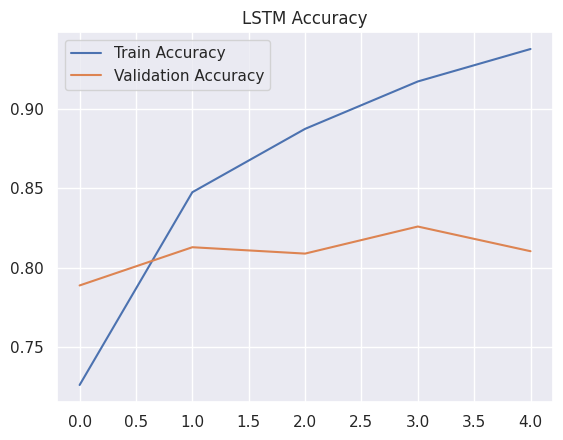

In [286]:
#Evalution
plt.plot(LSTM_Hitory.history['accuracy'], label='Train Accuracy')
plt.plot(LSTM_Hitory.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()

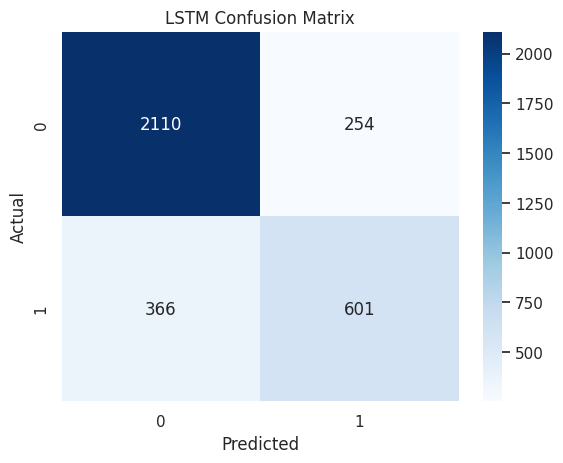

In [287]:
#LSTM Confusion Matrix
LSTM_CM = confusion_matrix(y_test, y_lstm_pred)

sns.heatmap(LSTM_CM, annot=True,fmt = 'd',cmap = 'Blues')
sns.set(font_scale=1)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **BI-LSTM Model**

In [288]:
#Build the BI-LSTM Model

#ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model_BIlstm = Sequential()
model_BIlstm.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model_BIlstm.add(Bidirectional(LSTM(LSTM_OUT)))
model_BIlstm.add(Dense(1, activation='sigmoid'))

#print(model_lstm.summary())

In [289]:
#Set Hyperparameters
model_BIlstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [290]:
#BI-LSTM Model Training
checkpoint = ModelCheckpoint(
    'models/BI-LSTM.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [291]:
#Model Fitting
BILSTM_Hitory = model_BIlstm.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint, early_stop], validation_data=(x_val, y_val))

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6950 - loss: 0.6208
Epoch 1: val_accuracy improved from -inf to 0.78439, saving model to models/BI-LSTM.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.6954 - loss: 0.6200 - val_accuracy: 0.7844 - val_loss: 0.4535
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8352 - loss: 0.3765
Epoch 2: val_accuracy improved from 0.78439 to 0.81741, saving model to models/BI-LSTM.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8354 - loss: 0.3761 - val_accuracy: 0.8174 - val_loss: 0.3960
Epoch 3/5
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8893 - loss: 0.2649
Epoch 3: val_accuracy did not improve from 0.81741
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8893 - loss: 0.2648 - val_accuracy: 0.8149 - val_loss: 0.4093
Epoch 4/5
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9264 - loss: 0.1977
Epoch 4: val_accuracy did not improve from 0.81741
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9262 - loss: 0.1980 - val_accuracy: 0.8034 - val_loss: 0.4385
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9482 - loss: 0.1477
Epoch 5: val_accuracy did not improve from 0.81741
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9481 - loss: 0.1479 - val_accuracy: 0.8034 - val_loss: 0.5336


In [292]:
#BI-LSTM Model Testing
BIlstm_pred = model_BIlstm.predict(x = x_test)
y_BIlstm_pred = (BIlstm_pred >= 0.5) * 1

true = 0
for i, y in enumerate(y_test):
    if y == y_BIlstm_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(y_test.size - true))
print('Accuracy: {}'.format(true/len(y_BIlstm_pred)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Correct Prediction: 2707
Wrong Prediction: 624
Accuracy: 81.26688682077454


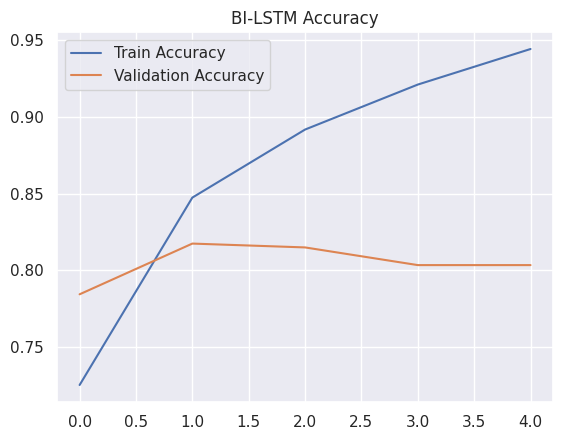

In [293]:
#Evalution
plt.plot(BILSTM_Hitory.history['accuracy'], label='Train Accuracy')
plt.plot(BILSTM_Hitory.history['val_accuracy'], label='Validation Accuracy')
plt.title('BI-LSTM Accuracy')
plt.legend()
plt.show()

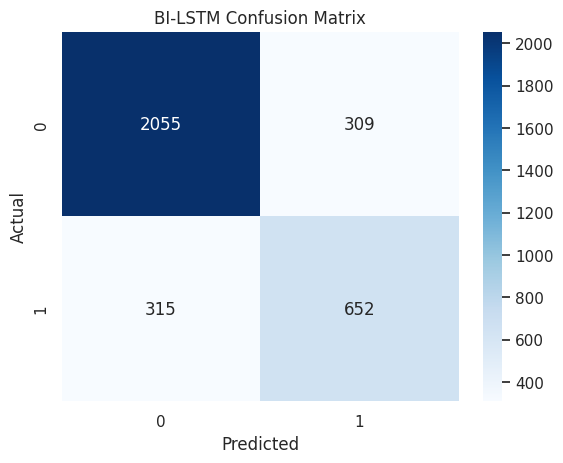

In [294]:
#Confusion Matrix
BILSTM_CM = confusion_matrix(y_test, y_BIlstm_pred)

sns.heatmap(BILSTM_CM, annot=True,fmt = 'd',cmap = 'Blues')
sns.set(font_scale=1)
plt.title('BI-LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Performance Comparison**

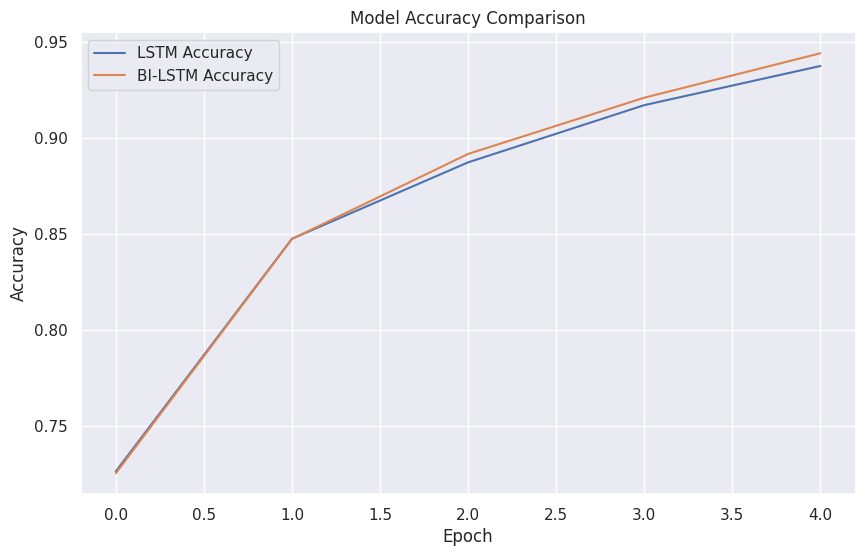

In [295]:
plt.figure(figsize=(10, 6))
plt.plot(LSTM_Hitory.history['accuracy'], label='LSTM Accuracy')
plt.plot(BILSTM_Hitory.history['accuracy'], label='BI-LSTM Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

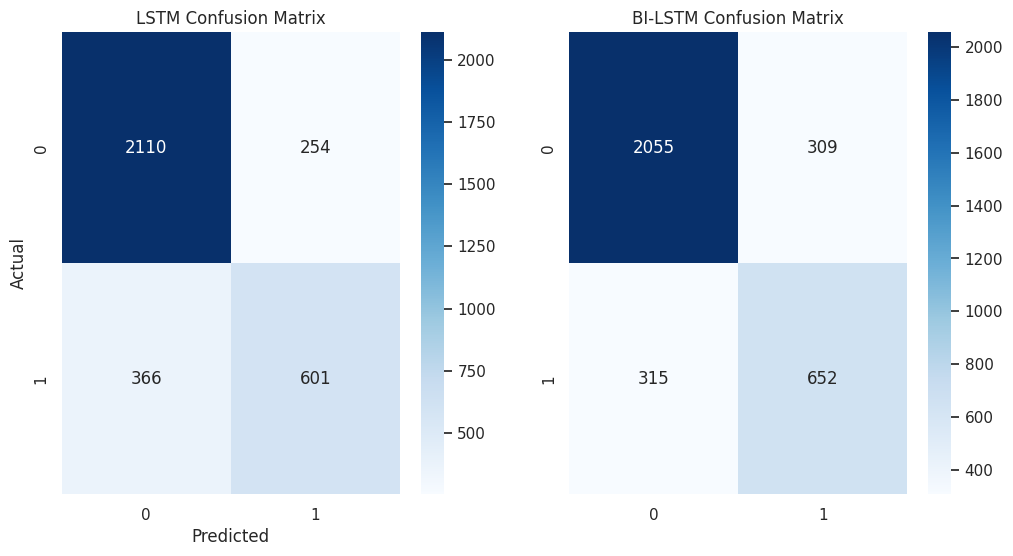

In [296]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.heatmap(LSTM_CM, annot=True,fmt = 'd',cmap = 'Blues')
sns.set(font_scale=1)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1,2,2)
sns.heatmap(BILSTM_CM, annot=True,fmt = 'd',cmap = 'Blues')
sns.set(font_scale=1)
plt.title('BI-LSTM Confusion Matrix')

plt.show()